# Basic Package Mangement

In [1]:
#install.packages("pacman") # Execute this once.
require(pacman)

Loading required package: pacman
Warning message:
"package 'pacman' was built under R version 3.6.3"

### Clearing and unloading packages

In [11]:
# Run this block, when done coding or before starting coding.
p_unload(all)
detach("package:datasets", unload=TRUE)
rm(list=ls()) # removes all previous stored variables

The following packages have been unloaded:
readxl, mosaic, ggridges, mosaicData, ggformula, ggstance, Matrix, lattice, forcats, stringr, dplyr, purrr, readr, tidyr, tibble, ggplot2, tidyverse, pacman



ERROR: Error in detach("package:datasets", unload = TRUE): invalid 'name' argument


### Loading packages

In [3]:
pacman::p_load(pacman, tidyverse, mosaic)

# Initializing the dataframe

In [4]:
library("readxl")
df <- read_excel("data/DeathsDK160321.xlsx")
df

interval,age,infected,tested,female_deaths,male_deaths,tot_deaths,comorbidity,infected_fem,infected_male,tot_male,tot_fem,tot_num
1,0-9,15400,395142,0,1,1,1,7372,8028,313571,297559,611130
2,10-19,34025,605344,0,0,0,0,16626,17399,348964,331889,680853
3,20-29,41545,688922,0,0,0,0,21296,20249,397572,381907,779479
4,30-39,30514,604186,4,2,6,3,15615,14899,352231,341194,693425
5,40-49,32482,646070,3,4,7,5,17345,15137,376117,375174,751291
6,50-59,31843,660087,21,32,53,37,16507,15336,402188,398825,801013
7,60-69,17558,490990,73,122,195,153,8562,8996,327021,338282,666262
8,70-79,10910,370426,229,395,624,516,5378,5532,272021,300894,572915
9,80-89,5760,140654,441,523,964,784,3330,2430,99560,135830,235390
10,90+,1805,28610,325,220,545,433,1277,528,13237,32228,45455


In [5]:
summary(df)

    interval        age               infected          tested       
 Min.   : 1.0   Length:11          Min.   :  1805   Min.   :  28610  
 1st Qu.: 3.5   Class :character   1st Qu.: 13155   1st Qu.: 382784  
 Median : 6.0   Mode  :character   Median : 30514   Median : 604186  
 Mean   : 6.0                      Mean   : 40335   Mean   : 841897  
 3rd Qu.: 8.5                      3rd Qu.: 33254   3rd Qu.: 653078  
 Max.   :11.0                      Max.   :221842   Max.   :4630431  
 female_deaths     male_deaths       tot_deaths      comorbidity    
 Min.   :   0.0   Min.   :   0.0   Min.   :   0.0   Min.   :   0.0  
 1st Qu.:   1.5   1st Qu.:   1.5   1st Qu.:   3.5   1st Qu.:   2.0  
 Median :  21.0   Median :  32.0   Median :  53.0   Median :  37.0  
 Mean   : 199.3   Mean   : 236.2   Mean   : 435.5   Mean   : 351.3  
 3rd Qu.: 277.0   3rd Qu.: 307.5   3rd Qu.: 584.5   3rd Qu.: 474.5  
 Max.   :1096.0   Max.   :1299.0   Max.   :2395.0   Max.   :1932.0  
  infected_fem    infected_

In [6]:
df_no_sum <- df[-c(11), ]
df_no_sum

interval,age,infected,tested,female_deaths,male_deaths,tot_deaths,comorbidity,infected_fem,infected_male,tot_male,tot_fem,tot_num
1,0-9,15400,395142,0,1,1,1,7372,8028,313571,297559,611130
2,10-19,34025,605344,0,0,0,0,16626,17399,348964,331889,680853
3,20-29,41545,688922,0,0,0,0,21296,20249,397572,381907,779479
4,30-39,30514,604186,4,2,6,3,15615,14899,352231,341194,693425
5,40-49,32482,646070,3,4,7,5,17345,15137,376117,375174,751291
6,50-59,31843,660087,21,32,53,37,16507,15336,402188,398825,801013
7,60-69,17558,490990,73,122,195,153,8562,8996,327021,338282,666262
8,70-79,10910,370426,229,395,624,516,5378,5532,272021,300894,572915
9,80-89,5760,140654,441,523,964,784,3330,2430,99560,135830,235390
10,90+,1805,28610,325,220,545,433,1277,528,13237,32228,45455


### Plotting and testing

In [7]:
k <- 100000 # The number og simulations
n <- df_no_sum[df_no_sum$interval == 10, ]$tested # Number of tested individuals of a certain agegroup in Denmark.
p_hat <- df_no_sum[df_no_sum$interval == 10, ]$tot_deaths / n # The estimated probability of dying with covid-19 in the specifik agegroup.
tot_infected_90 <- df_no_sum[df_no_sum$interval == 10, ]$infected # Estimated numbers of infected.

# Simulate number of infected of size tested, with probability of dying reapeat k times.
tot_deaths_90_sample <- replicate(k, rbinom(tot_infected_90, n, p_hat))
# Computing the mean of the simulated observations.
tot_deaths_90_sample_means <- apply(tot_deaths_90_sample, 2, mean)

# Get the 95% confidence interval.
quantile(tot_deaths_90_sample_means, c(0.025, 0.975))

2.5%    97.5% 
543.9385 546.0609

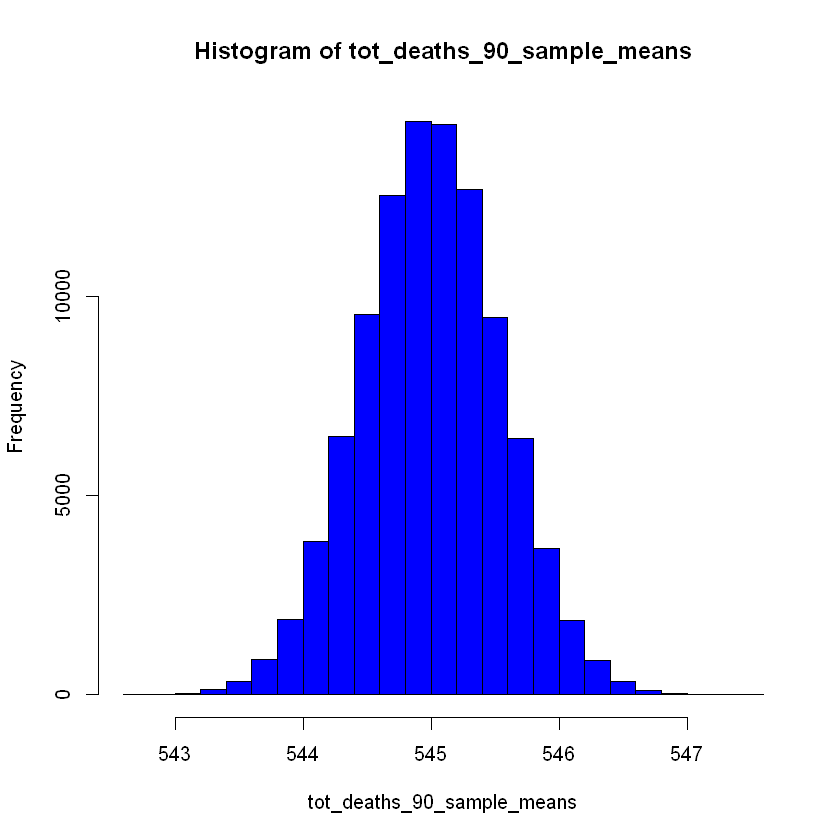

In [8]:
# Plot the result.
hist(tot_deaths_90_sample_means, col="blue", nclass=30)

### Hypotesetest

$H_0:$ Der er ingen signifikant forskel på dødeligheden i de forskellige aldersgrupper.